In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.optim import lr_scheduler
from tqdm import tqdm

from Player_Prep import Generate_Hitters, Generate_Hitter_Mutators, Generate_Test_Train
from Model import RNN_Model, RNN_Classification_Loss
from Constants import device
from Model_Train import trainAndGraph
from Dataset import HitterDataset

Player Input

In [2]:
fielding_components = 4
hitting_components = 5
stealing_components = 1
park_components = 2
person_components = 3
init_components = 3

input_size = fielding_components + hitting_components + stealing_components + park_components + person_components + init_components

In [3]:
hitter_input, hitter_output, (fielding_stddev,
                            hitting_stddev,
                            stealing_stddev,
                            park_stddev,
                            person_stddev) = Generate_Hitters(fielding_components,
                        hitting_components,
                        stealing_components,
                        park_components,
                        person_components)

Player Mutators

In [4]:
fielding_scale = 0.6
hitting_scale = 0.2
stealing_scale = 0.3
park_scale = 0.1
person_scale = 0.3
draft_scale = 0.2
signing_age_scale = 0.5

batch_size = 800
max_input_size = 79

In [5]:
hitting_mutators = Generate_Hitter_Mutators(batch_size, max_input_size,
                        fielding_components,fielding_scale,fielding_stddev,
                        hitting_components, hitting_scale, hitting_stddev,
                        stealing_components, stealing_scale, stealing_stddev,
                        park_components, park_scale, park_stddev,
                        person_components, person_scale, person_stddev,
                        draft_scale, signing_age_scale)

Test/Train Split

In [6]:
test_size = 0.2
random_state = 1

x_train_padded, x_test_padded, y_train_padded, y_test_padded, train_lengths, test_lengths = Generate_Test_Train(
    hitter_input, hitter_output, test_size, random_state)

train_hitters_dataset = HitterDataset(x_train_padded, train_lengths, y_train_padded)
test_hitters_dataset = HitterDataset(x_test_padded, test_lengths, y_test_padded)

Train Model

Epoch [1/300], Train Loss: 2.4404, Test Loss: 1.1966
Epoch [11/300], Train Loss: 0.8229, Test Loss: 0.7664
Epoch [21/300], Train Loss: 0.7045, Test Loss: 0.6834
Epoch [31/300], Train Loss: 0.6831, Test Loss: 0.6675
Epoch [41/300], Train Loss: 0.6653, Test Loss: 0.6507
Epoch [51/300], Train Loss: 0.6483, Test Loss: 0.6397
Epoch [61/300], Train Loss: 0.6455, Test Loss: 0.6276
Epoch [71/300], Train Loss: 0.6274, Test Loss: 0.6308
Epoch [81/300], Train Loss: 0.6033, Test Loss: 0.6279
Epoch [91/300], Train Loss: 0.5929, Test Loss: 0.6398
Epoch [101/300], Train Loss: 0.5904, Test Loss: 0.6502
Stopped Training Early
Best result at epoch=60 with loss=0.6276437044143677


0.6276437044143677

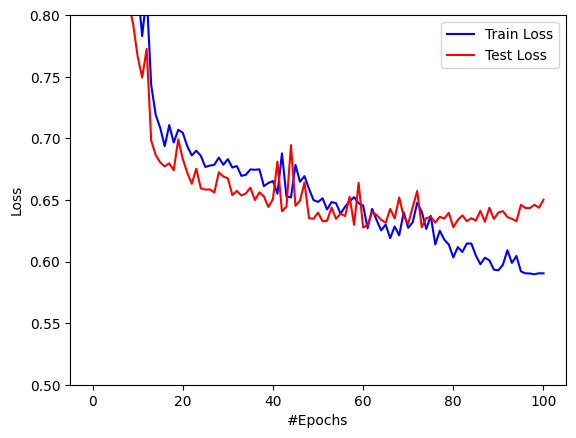

In [7]:
dropout_perc = 0.0
num_layers = 2
hidden_size = 50
network = RNN_Model(input_size, num_layers, hidden_size, dropout_perc, hitting_mutators)
network = network.to(device)

optimizer = torch.optim.Adam(network.parameters(), lr=0.003)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=20, cooldown=5, verbose=False)
loss_function = RNN_Classification_Loss

num_epochs = 300
training_generator = torch.utils.data.DataLoader(train_hitters_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(test_hitters_dataset, batch_size=batch_size, shuffle=False)

graph_y_range=(0.5,0.8)
trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, scheduler, num_epochs, 10, early_stopping_cutoff=40, should_output=True, graph_y_range=graph_y_range)